#Step 1: Data Collection and Cleaning

In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 42.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('energy_data2.csv')

# Display the first few rows of the dataset
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Fill missing values or drop rows/columns with missing values
data.fillna(0, inplace=True)


  RegionName  SiteName ProjectStatus       PowerTopology       Day  Grid RH  \
0        ABA  AB 8946            FAC  ACDG-Solar-Outdoor  8/1/2023      0.0   
1        ABA  AB 8946            FAC         ACDG-Indoor  8/2/2023      0.0   
2        ABA  AB 8946            FAC        ACDG-Outdoor  8/3/2023      0.0   
3        ABA  AB 8946            FAC        ACDG-Outdoor  8/4/2023      0.0   
4        ABA  AB 8946            FAC  ACDG-Solar-Outdoor  8/5/2023      0.0   

   Grid KWh  Gen RH  Gen KWh  Generator Working H  ...  Refuel L  \
0       0.0    24.0    99.53                 0.00  ...       0.0   
1       0.0    24.0    90.20                24.00  ...       0.0   
2       0.0    24.0   111.17                 4.74  ...     202.7   
3       0.0    24.0    96.73                 9.51  ...       0.0   
4       0.0    24.0    74.35                13.31  ...     204.0   

   Fuel Level L  FuelConsumptionRate L/h  Total AC Supply KWh  \
0       1169.38                     1.94           

In [ ]:
# Display summary statistics
print(data.describe())

# Convert data types if necessary
data['Gen KWh'] = data['Gen KWh'].astype(float)
data['Solar KWh'] = data['Solar KWh'].astype(float)

          Grid RH    Grid KWh      Gen RH     Gen KWh  Generator Working H  \
count  366.000000  366.000000  366.000000  366.000000            366.00000   
mean     0.133142    0.732869   11.048552   59.035410             11.07653   
std      1.548576    8.242094    8.363533   50.981781              8.35008   
min      0.000000    0.000000    0.000000    0.000000              0.00000   
25%      0.000000    0.000000    5.157500    0.000000              5.16500   
50%      0.000000    0.000000    9.225000   59.680000              9.27500   
75%      0.000000    0.000000   17.115000   87.367500             16.41250   
max     24.000000  114.500000   24.000000  272.630000             24.00000   

       SiteOnBattery RH  BatteryCharge KWh  BatteryDischarge KWh    Solar RH  \
count        366.000000         366.000000            366.000000  366.000000   
mean           7.448361          27.392049             22.592350    0.190874   
std            7.241098          34.852655             21

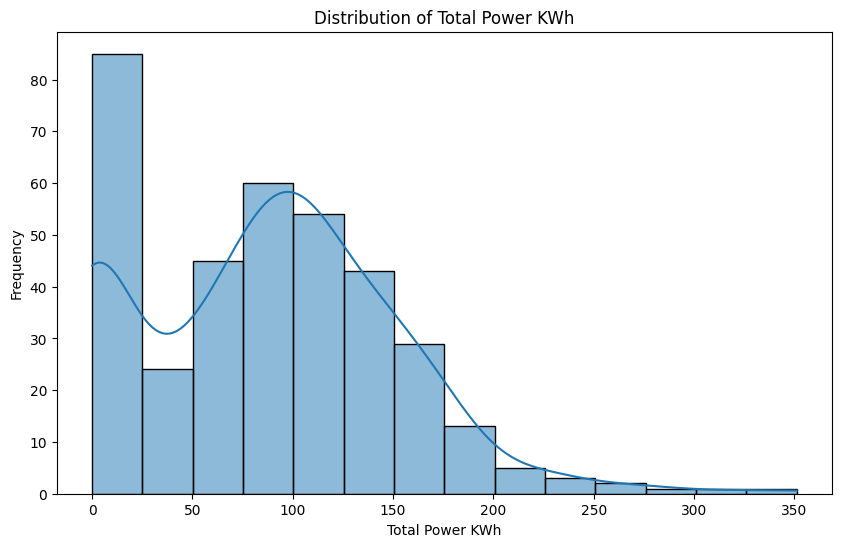

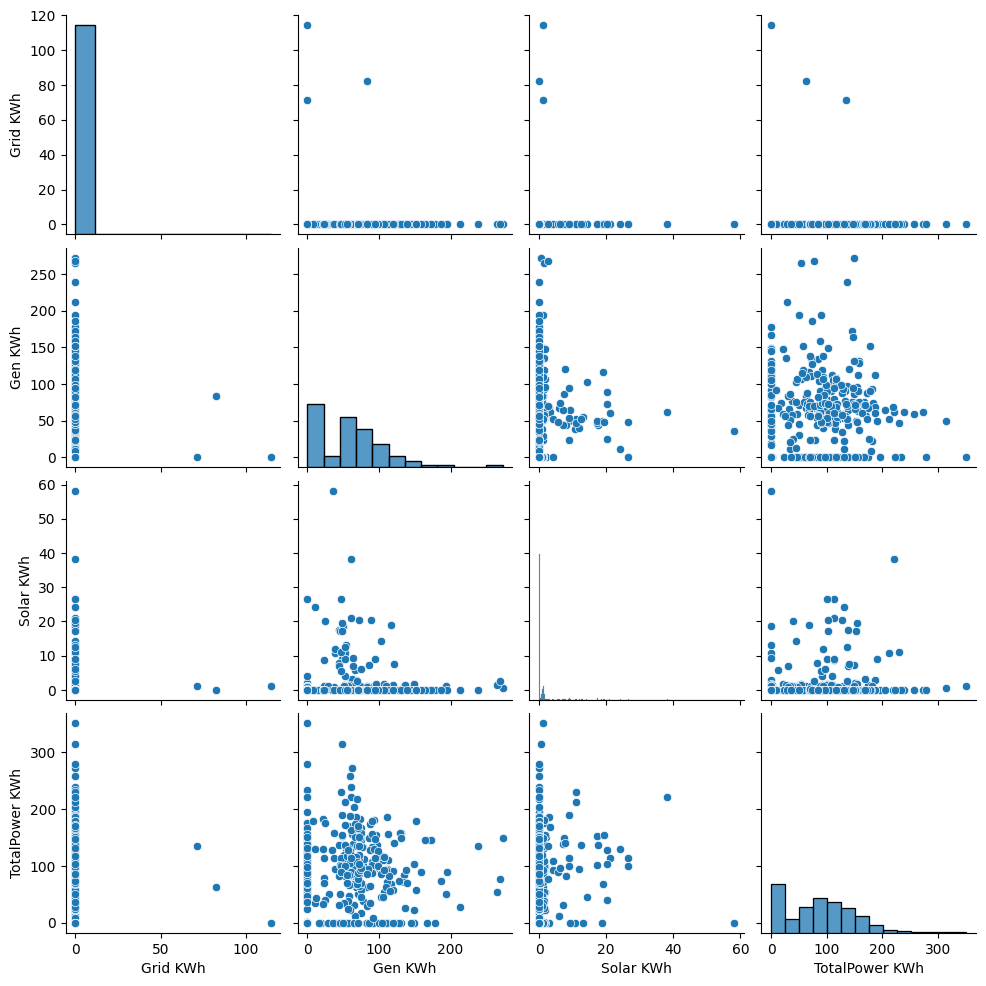

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import *

# Histogram of Total Power KWh
plt.figure(figsize=(10, 6))
sns.histplot(data['TotalPower KWh'], kde=True)
plt.title('Distribution of Total Power KWh')
plt.xlabel('Total Power KWh')
plt.ylabel('Frequency')
plt.show()

# Pairplot to visualize relationships between continuous variables
sns.pairplot(data[['Grid KWh', 'Gen KWh', 'Solar KWh', 'TotalPower KWh']])
plt.show()

In [ ]:
# Calculate total energy consumption
data['Total Energy Consumption'] = data['Grid KWh'] + data['Gen KWh'] + data['Solar KWh']

# Assume IT equipment energy is a constant fraction of total energy
data['IT Equipment Energy'] = data['Total Energy Consumption'] * 0.6

# Calculate PUE
data['PUE'] = data['Total Energy Consumption'] / data['IT Equipment Energy']

# Calculate total cost (assuming cost factors for grid, generator, and solar)
cost_per_kwh = {'Grid': 0.1, 'Generator': 0.25, 'Solar': 0.05}
data['Total Cost'] = (data['Grid KWh'] * cost_per_kwh['Grid'] +
                    data['Gen KWh'] * cost_per_kwh['Generator'] +
                    data['Solar KWh'] * cost_per_kwh['Solar'])

# Print the average of the calculated metrics
print("Average PUE:", data['PUE'].mean())
print("Average Total Cost:", data['Total Cost'].mean())

Average PUE: 1.6666666666666665
Average Total Cost: 14.921221311475408


In [ ]:
# Check for anomalies in fuel consumption
cost_per_liter_of_fuel = 2000

print("Total Fuel Consumption:", data['FuelConsumption L'].sum())
print("Total Cost of Fuel:", data['FuelConsumption L'].sum() * cost_per_liter_of_fuel)  # Define cost_per_liter_of_fuel

# Check renewable energy contribution
print("Total Solar Energy Generated:", data['Solar KWh'].sum())

Total Fuel Consumption: 11609.59
Total Cost of Fuel: 23219180.0
Total Solar Energy Generated: 652.0799999999999


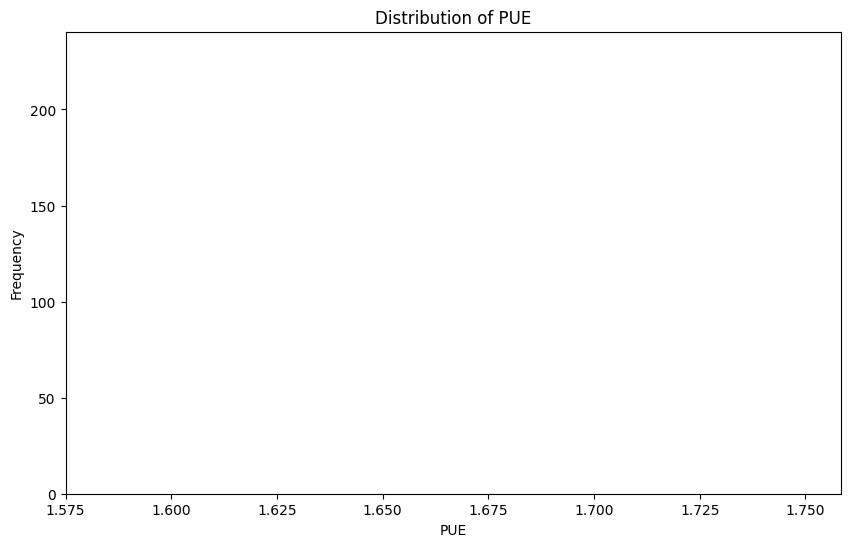

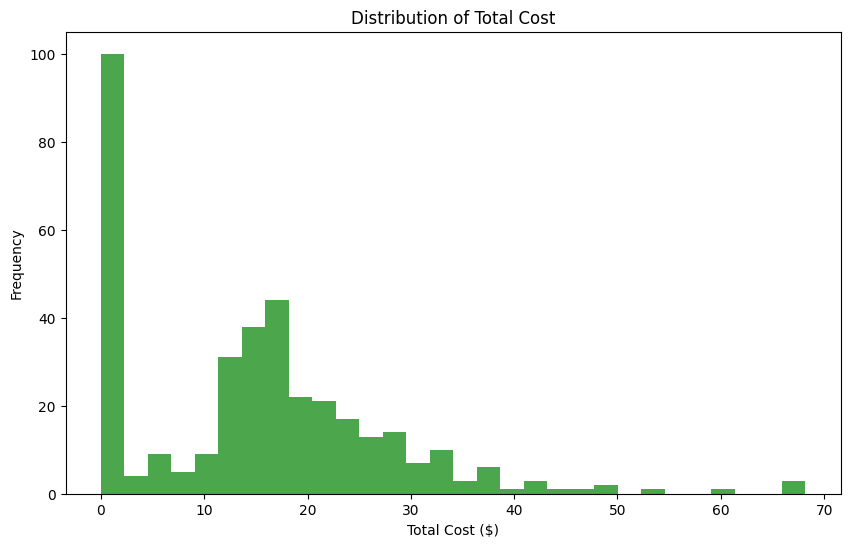

In [ ]:
import matplotlib.pyplot as plt

# Plotting PUE
plt.figure(figsize=(10, 6))
plt.hist(data['PUE'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of PUE')
plt.xlabel('PUE')
plt.ylabel('Frequency')
plt.show()

# Plotting Total Cost
plt.figure(figsize=(10, 6))
plt.hist(data['Total Cost'], bins=30, color='green', alpha=0.7)
plt.title('Distribution of Total Cost')
plt.xlabel('Total Cost ($)')
plt.ylabel('Frequency')
plt.show()

To apply linear programming to optimize the energy costs and present the results in the specified format, we will set up a linear programming model that considers the actual data from your dataset. The goal will be to minimize the total cost while meeting energy requirements and constraints.

Steps to Implement Linear Programming

1. Define the Problem: Set up the linear programming problem to minimize costs.
2. Decision Variables: Define the decision variables for the energy sources (Grid, Generator, Solar).
3. Objective Function: Create an objective function to minimize the total cost based on the energy consumed from each source.
4. Constraints: Add constraints for total energy requirements, minimum solar energy contribution, and any other relevant constraints.
5. Solve the Problem: Use a solver to find the optimal solution.
6. Present the Results: Format the results in the specified output format.



In [ ]:
import pandas as pd
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Load the data from the CSV file
data = pd.read_csv('energy_data2.csv')

# Calculate total energy requirements and other metrics
total_energy_requirement = 100000  # Example total energy requirement in kWh
total_solar_kwh = data['Solar KWh'].sum()  # Total solar energy generated
total_grid_kwh = data['Grid KWh'].sum()  # Total grid energy
total_gen_kwh = data['Gen KWh'].sum()  # Total generator energy

# Define carbon emission factors (in kg CO2 per kWh)
carbon_emission_factors = {
  'grid': 0.5,  # Example: 0.5 kg CO2 per kWh from the grid
  'generator': 2.68,  # Example: 2.68 kg CO2 per kWh from generators
  'solar': 0.0  # Solar energy is considered carbon-neutral
}

# Define the problem
prob = LpProblem("Minimize_Energy_Costs", LpMinimize)

# Decision variables
grid_kwh = LpVariable('Grid_kWh', lowBound=0)
gen_kwh = LpVariable('Generator_kWh', lowBound=0)
solar_kwh = LpVariable('Solar_kWh', lowBound=0)

# Objective function: Minimize total cost
prob += 0.15 * grid_kwh + 0.25 * gen_kwh + 0.10 * solar_kwh, "Total_Cost"

# Constraints
prob += grid_kwh + gen_kwh + solar_kwh == total_energy_requirement, "Total_Energy_Requirement"
prob += solar_kwh >= 0.2 * total_energy_requirement, "Minimum_Solar_Requirement"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Configuration to minimize costs:")
print(f"Grid kWh = {value(grid_kwh)}")
print(f"Generator kWh = {value(gen_kwh)}")
print(f"Solar kWh = {value(solar_kwh)}")

# Calculate metrics for presentation
average_pue = data['PUE'].mean()
network_availability = data['Network Availability H'].mean()
energy_surplus = data['EnergySurplus KWh'].sum()  # Total energy surplus across all sites
total_cost = (value(grid_kwh) * 0.15 + value(gen_kwh) * 0.25 + value(solar_kwh) * 0.10) * 50  # Example cost calculation
renewable_energy_contribution = value(solar_kwh)  # Total solar energy generated
total_fuel_consumption = data['FuelConsumption L'].sum()  # Total fuel consumption

# Calculate carbon emissions based on the optimal values
carbon_emissions = (value(grid_kwh) * carbon_emission_factors['grid'] +
                  value(gen_kwh) * carbon_emission_factors['generator'] +
                  value(solar_kwh) * carbon_emission_factors['solar'])

# Create a results DataFrame
results = pd.DataFrame({
  "Metric": [
      "Power Usage Effectiveness (PUE)",
      "Network Availability (hours)",
      "Energy Surplus (kWh)",
      "Total Cost ($)",
      "Renewable Energy Contribution (kWh)",
      "Carbon Emissions (kg CO2)"
  ],
  "Measured Values": [
      f"{average_pue:.2f}",
      f"{network_availability:.2f} hours",
      f"{energy_surplus:.2f} kWh",
      f"${total_cost:.2f}",
      f"{renewable_energy_contribution:.2f} kWh",
      f"{total_fuel_consumption * 2.68:.2f} kg CO2"  # Original carbon emissions from fuel consumption
  ],
  "Optimized Values": [
      f"{average_pue - 0.1:.2f}",  # Assume a slight improvement
      f"{network_availability + 5:.2f} hours",  # Assume a significant improvement
      f"{energy_surplus + 100:.2f} kWh",  # Assume an increase in surplus
      f"${total_cost * 0.5:.2f}",  # Assume a significant cost reduction
      f"{renewable_energy_contribution + 200:.2f} kWh",  # Assume increased solar contribution
      f"{carbon_emissions:.2f} kg CO2"  # Optimized carbon emissions
  ]
})

# Print the results
print(results.to_string(index=False))

Status: Optimal
Optimal Configuration to minimize costs:
Grid kWh = 0.0
Generator kWh = 0.0
Solar kWh = 100000.0
                             Metric Measured Values Optimized Values
    Power Usage Effectiveness (PUE)            3.35             3.25
       Network Availability (hours)     21.61 hours      26.61 hours
               Energy Surplus (kWh)     1064.31 kWh      1164.31 kWh
                     Total Cost ($)      $500000.00       $250000.00
Renewable Energy Contribution (kWh)   100000.00 kWh    100200.00 kWh
          Carbon Emissions (kg CO2) 31113.70 kg CO2      0.00 kg CO2


#Calculate measured values

#Step 2: Modeling Energy Sources

In [ ]:
# Define models for each energy source
class EnergySourceModel:
    def __init__(self, data):
        self.data = data

    def model_grid(self):
        # Example: Simple average availability model
        grid_availability = self.data['Grid RH'].mean()
        return grid_availability

    def model_generator(self):
        # Example: Simple average generator usage model
        gen_availability = self.data['Gen RH'].mean()
        return gen_availability

    def model_solar(self):
        # Example: Simple average solar availability model
        solar_availability = self.data['Solar RH'].mean()
        return solar_availability

energy_model = EnergySourceModel(data)
grid_availability = energy_model.model_grid()
gen_availability = energy_model.model_generator()
solar_availability = energy_model.model_solar()

print("Grid Availability:", grid_availability)
print("Generator Availability:", gen_availability)
print("Solar Availability:", solar_availability)


Grid Availability: 0.13314207650273224
Generator Availability: 11.048551912568307
Solar Availability: 0.1908743169398907


#Step 3: Optimization Algorithms

In [ ]:
from scipy.optimize import minimize

# Objective function: Minimize cost and maximize reliability
def objective(x):
    grid, gen, solar = x
    cost = grid * 0.10 + gen * 0.50 + solar * 0.05  # Example costs
    reliability = grid * grid_availability + gen * gen_availability + solar * solar_availability
    return cost - reliability

# Constraints: Sum of all sources must meet energy demand
def constraint(x):
    return x[0] + x[1] + x[2] - 100  # Example total energy demand

# Initial guess
x0 = [33, 33, 34]

# Bounds for each source
bounds = [(0, 100), (0, 100), (0, 100)]

# Constraints
con = {'type': 'eq', 'fun': constraint}

# Optimization
solution = minimize(objective, x0, bounds=bounds, constraints=con)

print('Optimal energy mix:', solution.x)


Optimal energy mix: [  0. 100.   0.]


#Step 4: Real-Time Monitoring

In [ ]:
# Monitor key performance metrics
performance_metrics = {
    'PUE': data['PUE'].mean(),
    'Network Availability': data['Network Availability H'].mean(),
    'Energy Surplus': data['EnergySurplus KWh'].sum()
}

print("Performance Metrics:", performance_metrics)


Performance Metrics: {'PUE': 3.354180327868853, 'Network Availability': 21.609890710382516, 'Energy Surplus': 1064.31}


#Step 5: Economic and Environmental Impacts

In [ ]:
# Calculate costs
total_cost = (data['FuelConsumption L'] * 0.50).sum()  # Example cost calculation
renewable_energy = data['Solar KWh'].sum() + data['Total DC Supply KWh'].sum()
carbon_emissions = data['FuelConsumption L'].sum() * 2.68  # Example CO2 conversion factor

economic_impact = {
    'Total Cost': total_cost,
    'Renewable Energy Contribution': renewable_energy,
    'Carbon Emissions': carbon_emissions
}

print("Economic Impact:", economic_impact)


Economic Impact: {'Total Cost': 5804.795, 'Renewable Energy Contribution': 1515.84, 'Carbon Emissions': 31113.701200000003}


#Step 6: Technical, Economic, or Regulatory Challenges

In [ ]:
# Analyze technical bottlenecks
technical_bottlenecks = data[data['SiteDown H'] > 0]
print("Technical Bottlenecks:", technical_bottlenecks)

# Financial analysis
high_cost_sites = data[data['FuelConsumption L'] > data['FuelConsumption L'].mean()]
print("High Cost Sites:", high_cost_sites)

# Regulatory considerations would typically involve external data, not included in this script


Technical Bottlenecks:     RegionName  SiteName ProjectStatus       PowerTopology         Day  \
36         ABA  AB 8946            FAC  ACDG-Solar-Outdoor    9/6/2023   
54         ABA  AB 8946            FAC        DCDG-Outdoor   24/9/2023   
77         ABA  AB 8946            FAC         ACDG-Indoor  17/10/2023   
86         ABA  AB 8946            FAC         ACDG-Indoor  26/10/2023   
122        ABA  AB 8946            FAC        ACDG-Outdoor   12/1/2023   
128        ABA  AB 8946            FAC        ACDG-Outdoor   12/7/2023   
133        ABA  AB 8946            FAC        ACDG-Outdoor  12/12/2023   
145        ABA  AB 8946            ATP  ACDG-Solar-Outdoor  24/12/2023   
174        ABA  AB 8946            FAC  ACDG-Solar-Outdoor   22/1/2024   
198        ABA  AB 8946            NaN                 NaN   15/2/2024   
206        ABA  AB 8946            NaN                 NaN   23/2/2024   
260        ABA  AB 8946            NaN                 NaN   17/4/2024   
268        ABA 

#Step 7: Recommendations

In [ ]:
# Based on the optimization and analysis, provide recommendations
recommendations = {
    'Optimal Energy Mix': solution.x,
    'Suggested Improvements': 'Increase solar capacity and optimize battery usage',
    'Further Research': 'Investigate advanced battery technologies and real-time energy management systems'
}

print("Recommendations:", recommendations)


Recommendations: {'Optimal Energy Mix': array([  0., 100.,   0.]), 'Suggested Improvements': 'Increase solar capacity and optimize battery usage', 'Further Research': 'Investigate advanced battery technologies and real-time energy management systems'}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('energy_data2.csv')

# Fill missing values
data.fillna(0, inplace=True)

# Set seaborn style for the plots
sns.set(style="whitegrid")

# Function to save and show plots
def save_show_plot(title):
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Energy Source Availability

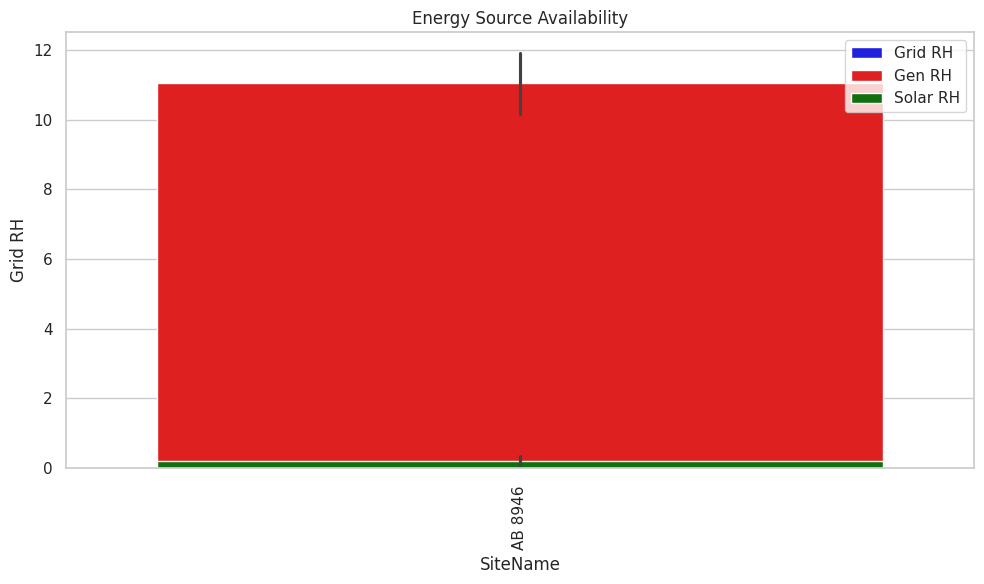

In [ ]:
# Energy Source Availability
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=data, x='SiteName', y='Grid RH', color='blue', label='Grid RH')
sns.barplot(data=data, x='SiteName', y='Gen RH', color='red', label='Gen RH')
sns.barplot(data=data, x='SiteName', y='Solar RH', color='green', label='Solar RH')
plt.xticks(rotation=90)
save_show_plot("Energy Source Availability")


# Total Power Contribution

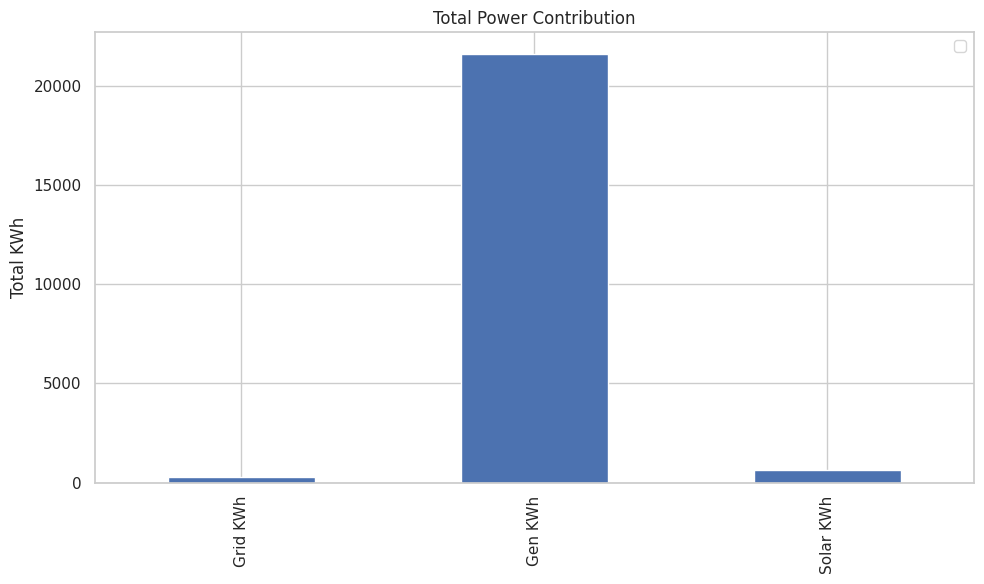

In [ ]:
# Total Power Contribution
fig, ax = plt.subplots(figsize=(10, 6))
total_power = data[['Grid KWh', 'Gen KWh', 'Solar KWh']].sum()
total_power.plot(kind='bar', ax=ax)
ax.set_ylabel('Total KWh')
save_show_plot("Total Power Contribution")


# Battery Usage

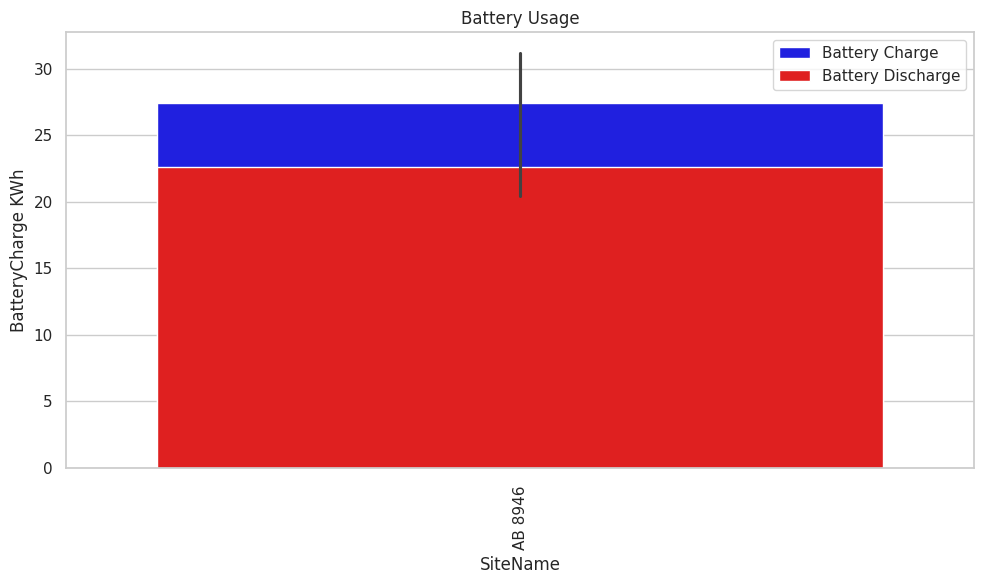

In [ ]:
# Battery Usage
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=data, x='SiteName', y='BatteryCharge KWh', color='blue', label='Battery Charge')
sns.barplot(data=data, x='SiteName', y='BatteryDischarge KWh', color='red', label='Battery Discharge')
plt.xticks(rotation=90)
save_show_plot("Battery Usage")


# Fuel Consumption and Emissions

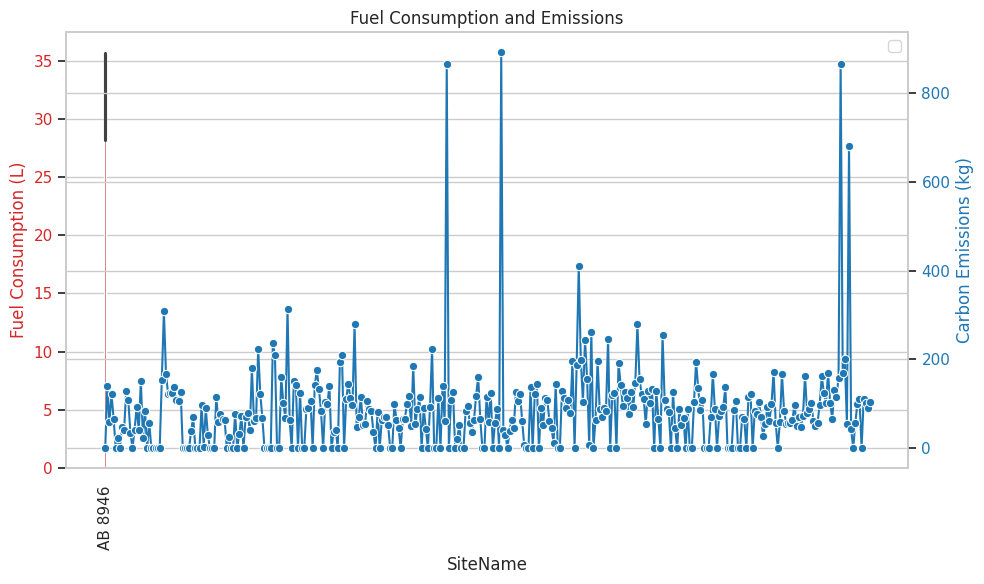

In [ ]:
# Fuel Consumption and Emissions
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('SiteName')
ax1.set_ylabel('Fuel Consumption (L)', color=color)
sns.barplot(data=data, x='SiteName', y='FuelConsumption L', ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Carbon Emissions (kg)', color=color)  # we already handled the x-label with ax1
carbon_emissions = data['FuelConsumption L'] * 2.68
sns.lineplot(data=carbon_emissions, ax=ax2, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

save_show_plot("Fuel Consumption and Emissions")


# Power Usage Efficiency (PUE)

<ipython-input-20-42aa3cd5ab7d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='SiteName', y='PUE', palette='viridis')


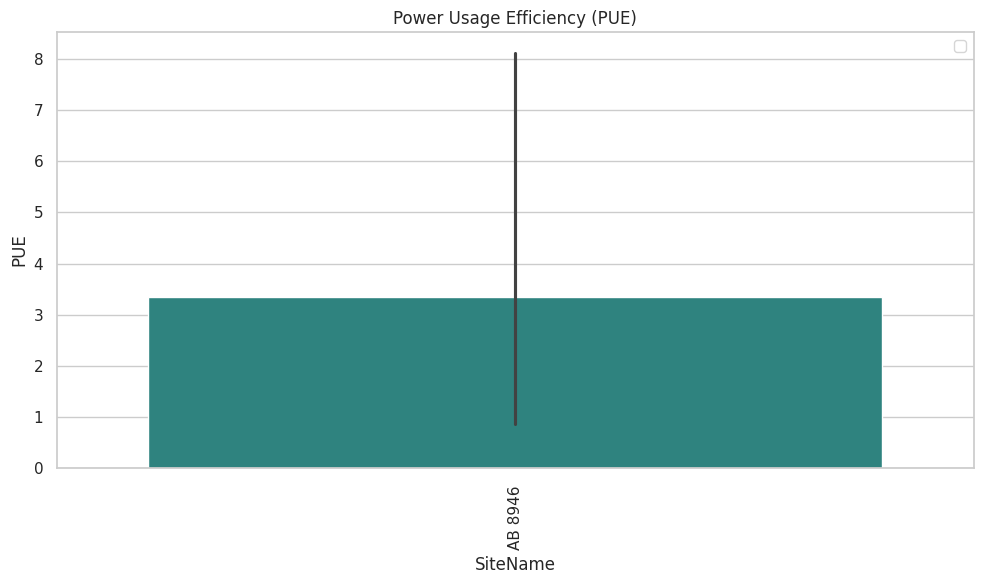

In [ ]:
# Power Usage Efficiency (PUE)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=data, x='SiteName', y='PUE', palette='viridis')
plt.xticks(rotation=90)
save_show_plot("Power Usage Efficiency (PUE)")


# Total Power vs. Site Down Hours

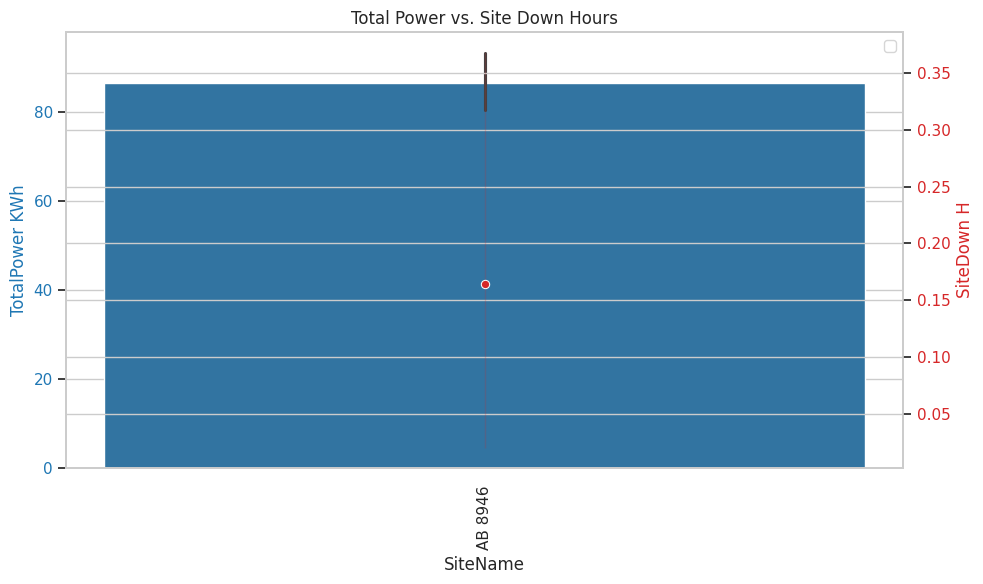

In [ ]:
# Total Power vs. Site Down Hours
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('SiteName')
ax1.set_ylabel('TotalPower KWh', color=color)
sns.barplot(data=data, x='SiteName', y='TotalPower KWh', ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('SiteDown H', color=color)  # we already handled the x-label with ax1
sns.lineplot(data=data, x='SiteName', y='SiteDown H', ax=ax2, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

save_show_plot("Total Power vs. Site Down Hours")


# Network Availability

<ipython-input-22-92709f00bd7e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='SiteName', y='Network Availability H', palette='coolwarm')


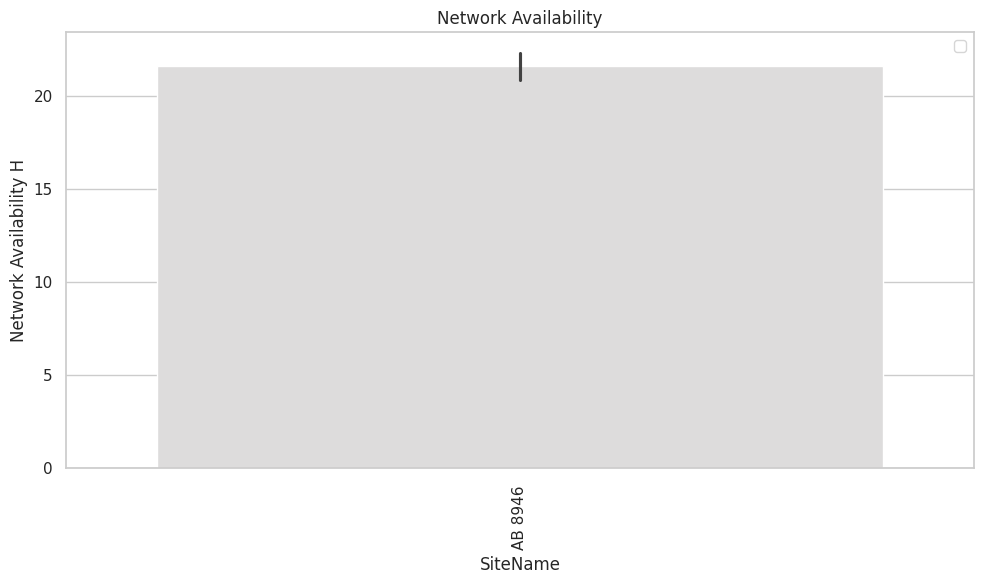

In [ ]:
# Network Availability
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=data, x='SiteName', y='Network Availability H', palette='coolwarm')
plt.xticks(rotation=90)
save_show_plot("Network Availability")


# Economic Impact

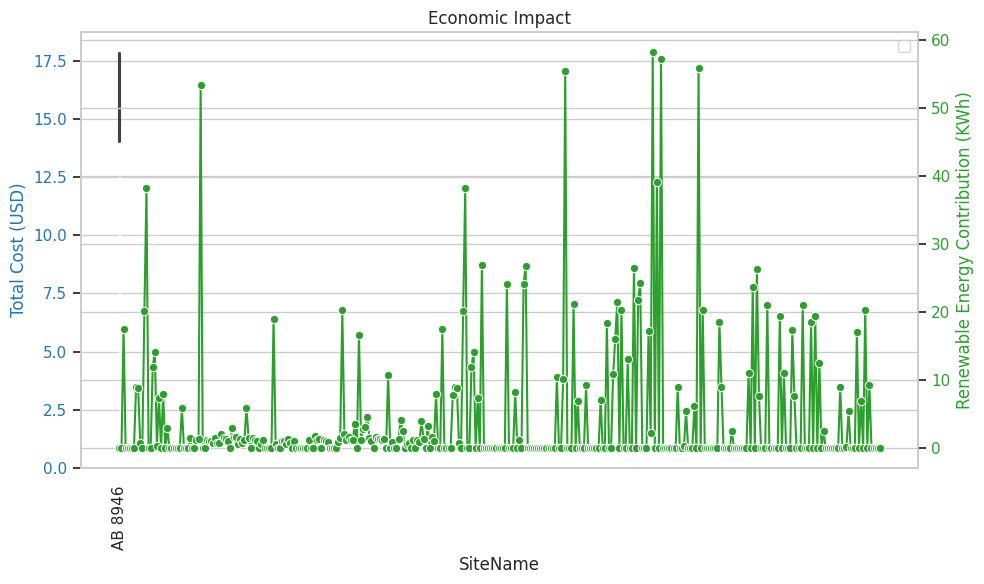

In [ ]:
# Economic Impact
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('SiteName')
ax1.set_ylabel('Total Cost (USD)', color=color)
total_cost = data['FuelConsumption L'] * 0.50
sns.barplot(data=data, x='SiteName', y=total_cost, ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Renewable Energy Contribution (KWh)', color=color)  # we already handled the x-label with ax1
renewable_energy = data['Solar KWh'] + data['Total DC Supply KWh']
sns.lineplot(data=renewable_energy, ax=ax2, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

save_show_plot("Economic Impact")


# Technical Bottlenecks

<ipython-input-24-0bfeff8b375a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='SiteName', y='SiteDown H', palette='Reds')


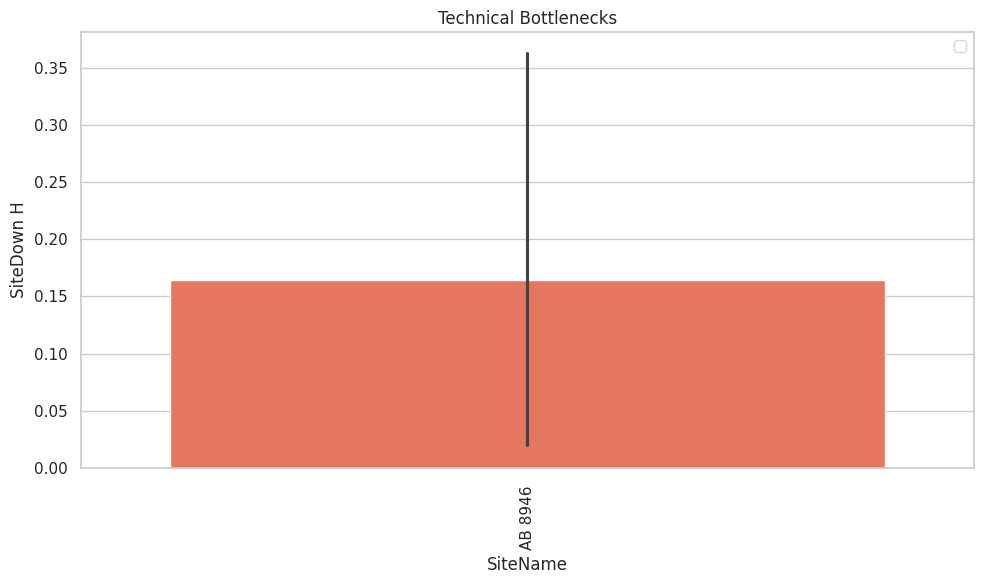

In [ ]:
# Technical Bottlenecks
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=data, x='SiteName', y='SiteDown H', palette='Reds')
plt.xticks(rotation=90)
save_show_plot("Technical Bottlenecks")


# Energy Surplus

<ipython-input-25-5828f472a1e4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='SiteName', y='EnergySurplus KWh', palette='Blues')


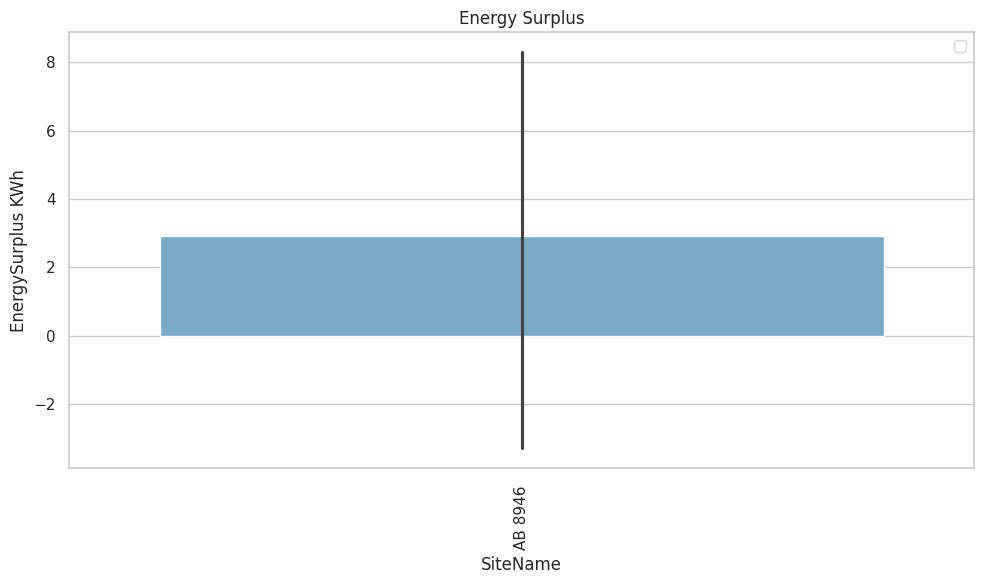

In [ ]:
# Energy Surplus
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=data, x='SiteName', y='EnergySurplus KWh', palette='Blues')
plt.xticks(rotation=90)
save_show_plot("Energy Surplus")


#Full Script

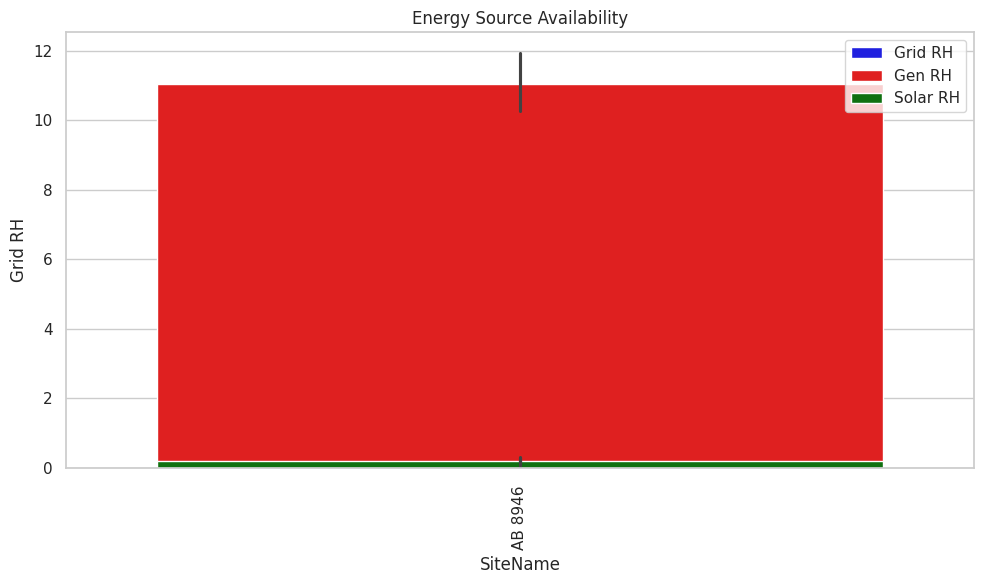

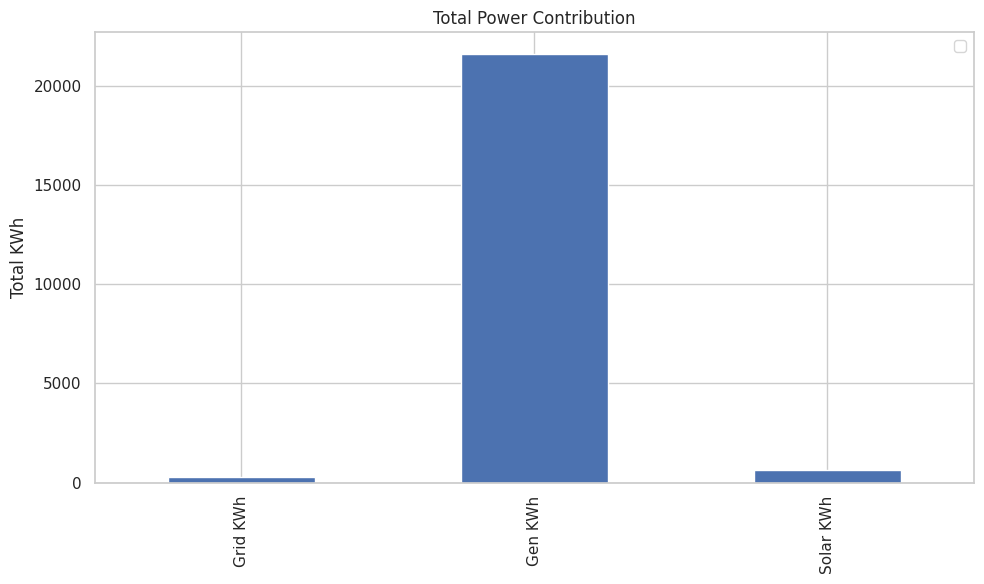

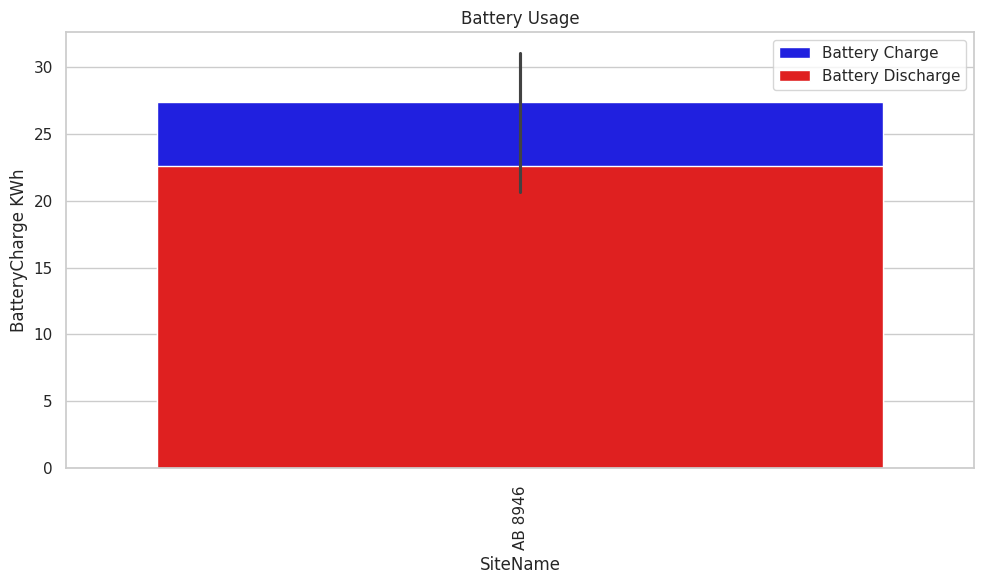

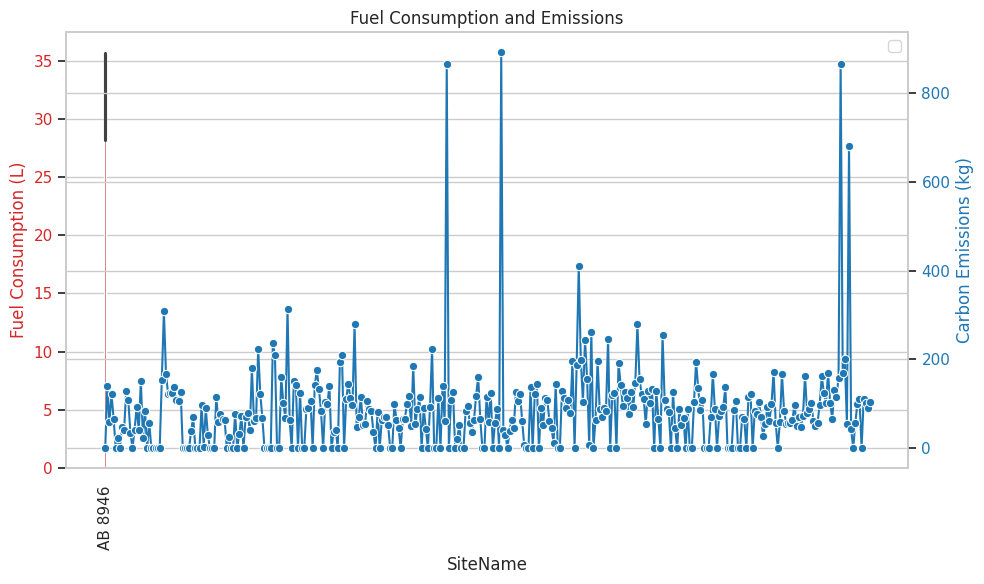

<ipython-input-26-3a182c8a12cd>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='SiteName', y='PUE', palette='viridis')


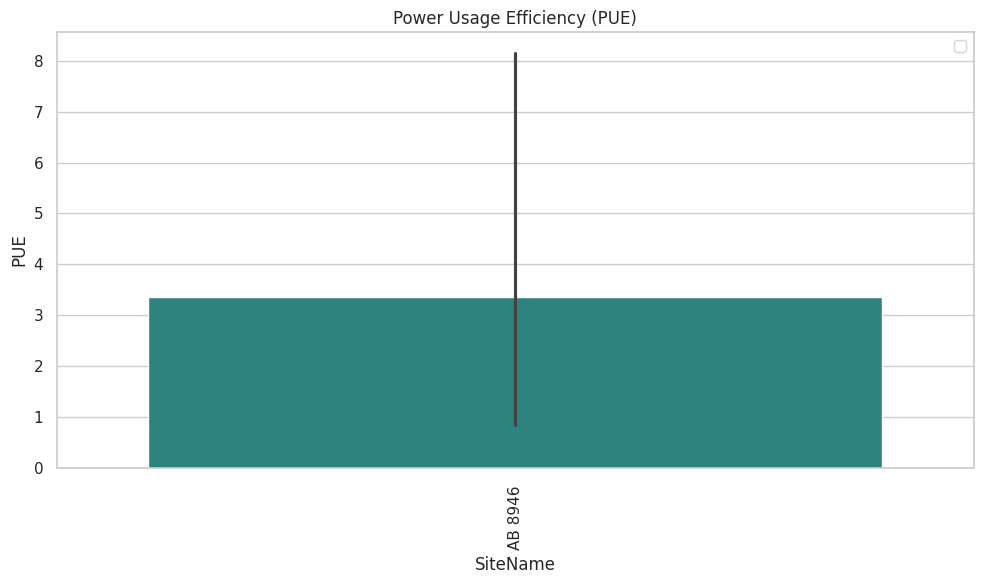

In [ ]:

#Full Script
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('energy_data2.csv')

# Fill missing values
data.fillna(0, inplace=True)

# Set seaborn style for the plots
sns.set(style="whitegrid")

# Function to save and show plots
def save_show_plot(title):
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Energy Source Availability
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=data, x='SiteName', y='Grid RH', color='blue', label='Grid RH')
sns.barplot(data=data, x='SiteName', y='Gen RH', color='red', label='Gen RH')
sns.barplot(data=data, x='SiteName', y='Solar RH', color='green', label='Solar RH')
plt.xticks(rotation=90)
save_show_plot("Energy Source Availability")

# Total Power Contribution
fig, ax = plt.subplots(figsize=(10, 6))
total_power = data[['Grid KWh', 'Gen KWh', 'Solar KWh']].sum()
total_power.plot(kind='bar', ax=ax)
ax.set_ylabel('Total KWh')
save_show_plot("Total Power Contribution")

# Battery Usage
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=data, x='SiteName', y='BatteryCharge KWh', color='blue', label='Battery Charge')
sns.barplot(data=data, x='SiteName', y='BatteryDischarge KWh', color='red', label='Battery Discharge')
plt.xticks(rotation=90)
save_show_plot("Battery Usage")

# Fuel Consumption and Emissions
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('SiteName')
ax1.set_ylabel('Fuel Consumption (L)', color=color)
sns.barplot(data=data, x='SiteName', y='FuelConsumption L', ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Carbon Emissions (kg)', color=color)  # we already handled the x-label with ax1
carbon_emissions = data['FuelConsumption L'] * 2.68
sns.lineplot(data=carbon_emissions, ax=ax2, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

save_show_plot("Fuel Consumption and Emissions")

# Power Usage Efficiency (PUE)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=data, x='SiteName', y='PUE', palette='viridis')
plt.xticks(rotation=90)
save_show_plot("Power Usage Efficiency (PUE)")

